In [3]:
# !pip install -r "requirements.txt"

In [4]:
import os
import zipfile
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
# Libraries for do visualization
import matplotlib.image as mpimg
import datetime
import os

# Data handling and numerical operations
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import load_img

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten,
    GlobalAveragePooling2D, Rescaling, Normalization
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, TensorBoard, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session

# Scikit-learn for model evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [5]:
from PIL import Image


In [6]:
class DataPreparation:
    def __init__(self, org_path, dest):
      self.zip_path = org_path
      self.destination_folder = dest

    def clear_destination_folder(self,original=True):
        for item in os.listdir(self.destination_folder):
            item_path = os.path.join(self.destination_folder, item)
            if original:
              if os.path.isdir(item_path) and item in ['train', 'val', 'test']:
                continue
              shutil.rmtree(item_path, ignore_errors=True)
            else:
              if os.path.isdir(item_path) and item not in ['train', 'val', 'test']:
                continue
              shutil.rmtree(item_path, ignore_errors=True)

    def print_class_counts(self):
      try:
        class_names = sorted(os.listdir(self.destination_folder))
        for class_name in class_names:
          class_path = os.path.join(self.destination_folder, class_name)
          if os.path.isdir(class_path):
            contents = os.listdir(class_path)
            print(f"{class_name}: {len(contents)}")
          else:
            print(f"{class_name} is not a directory.")
      except FileNotFoundError:
        print(f"The path '{self.destination_folder}' does not exist.")

    def split_data(self, test_size=0.2, val_size=0.25):
        self.clear_destination_folder(original=False)
        class_names = [d for d in os.listdir(self.destination_folder) if os.path.isdir(os.path.join(self.destination_folder, d))]

        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(self.destination_folder, split), exist_ok=True)
            for class_name in class_names:
                os.makedirs(os.path.join(self.destination_folder, split, class_name), exist_ok=True)

        for class_name in class_names:
            class_path = os.path.join(self.destination_folder, class_name)
            files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            print(files)
            if not files:
                continue

            # Split files into training+validation and test sets
            train_val_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

            # split training+validation files into training and validation sets
            train_files, val_files = train_test_split(train_val_files, test_size=val_size / (1 - test_size), random_state=42)

            # Move files to their new respective directories
            for file in train_files:
                shutil.move(os.path.join(class_path, file), os.path.join(self.destination_folder, 'train', class_name, file))
            for file in val_files:
                shutil.move(os.path.join(class_path, file), os.path.join(self.destination_folder, 'val', class_name, file))
            for file in test_files:
                shutil.move(os.path.join(class_path, file), os.path.join(self.destination_folder, 'test', class_name, file))

            print(f"Processed {class_name}: Train files: {len(train_files)}, Validation files: {len(val_files)}, Test files: {len(test_files)}")
        self.clear_destination_folder()


In [12]:
destination_folder=os.getcwd() + "\\fruit_dataset\\"
train_dir=os.path.join(destination_folder, 'train')
val_dir=os.path.join(destination_folder, 'val')
test_dir=os.path.join(destination_folder, 'test')
print(destination_folder)

c:\Users\Elizabeth\Documents\Github\project-proposal-ml\fruit_dataset\


In [13]:
original_path =os.getcwd() + "\\dataset\\"
data_preprocessor = DataPreparation(original_path, destination_folder)
data_preprocessor.print_class_counts()
data_preprocessor.split_data(test_size=0.15,val_size=0.2)


fresh_peaches_done: 250
fresh_pomegranates_done: 311
fresh_strawberries_done: 250
rotten_peaches_done: 343
rotten_pomegranates_done: 250
rotten_strawberries_done: 251
test: 0
train: 0
val: 0
['fresh_peach_1.jpg', 'fresh_peach_10.jpg', 'fresh_peach_100.jpg', 'fresh_peach_101.jpg', 'fresh_peach_102.jpg', 'fresh_peach_103.jpg', 'fresh_peach_104.jpg', 'fresh_peach_105.jpg', 'fresh_peach_106.jpg', 'fresh_peach_107.jpg', 'fresh_peach_108.jpg', 'fresh_peach_109.jpg', 'fresh_peach_11.jpg', 'fresh_peach_110.jpg', 'fresh_peach_111.jpg', 'fresh_peach_112.jpg', 'fresh_peach_113.jpg', 'fresh_peach_114.jpg', 'fresh_peach_115.jpg', 'fresh_peach_116.jpg', 'fresh_peach_117.jpg', 'fresh_peach_118.jpg', 'fresh_peach_119.jpg', 'fresh_peach_12.jpg', 'fresh_peach_120.jpg', 'fresh_peach_121.jpg', 'fresh_peach_122.jpg', 'fresh_peach_123.jpg', 'fresh_peach_124.jpg', 'fresh_peach_125.jpg', 'fresh_peach_126.jpg', 'fresh_peach_127.jpg', 'fresh_peach_128.jpg', 'fresh_peach_129.jpg', 'fresh_peach_13.jpg', 'fresh_pe

In [14]:
all_train_images = []

In [15]:
destination_folder=os.getcwd() + "\\fruit_dataset\\"
states = ["train"]
for state in states:
    state_path = os.path.join(destination_folder, state)
    class_names = sorted(os.listdir(state_path))
    for class_name in class_names:
        class_path = os.path.join(state_path, class_name)
        print(class_path)
        contents = os.listdir(class_path)
        for img in contents:
            img_path = os.path.join(class_path, img)
            all_train_images.append(img_path)
            

c:\Users\Elizabeth\Documents\Github\project-proposal-ml\fruit_dataset\train\fresh_peaches_done
c:\Users\Elizabeth\Documents\Github\project-proposal-ml\fruit_dataset\train\fresh_pomegranates_done
c:\Users\Elizabeth\Documents\Github\project-proposal-ml\fruit_dataset\train\fresh_strawberries_done
c:\Users\Elizabeth\Documents\Github\project-proposal-ml\fruit_dataset\train\rotten_peaches_done
c:\Users\Elizabeth\Documents\Github\project-proposal-ml\fruit_dataset\train\rotten_pomegranates_done
c:\Users\Elizabeth\Documents\Github\project-proposal-ml\fruit_dataset\train\rotten_strawberries_done


In [16]:
image = Image.open(all_train_images[0])
standard_size = image.size


In [17]:
labels = []
D = []
for i in range(len(all_train_images)):
    image = Image.open(all_train_images[i])
    ## Gray Scale Conversion
    image = image.convert('L')
    im = np.array(image)
    # Row-Major Format
    im = im.ravel(order='K')
    # Labels from the filename
    currlabel = all_train_images[i].split(".jpg")[0].split("train")[1].split("\\")[1]
    labels.append(currlabel)
    D.append(im)
D = np.array(D)

In [18]:
print(len(all_train_images))

1071


In [19]:
print(D)

[[255 255 255 ... 253 252 251]
 [255 255 255 ... 255 255 255]
 [254 254 254 ... 254 254 254]
 ...
 [  0   0   0 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [250 250 250 ... 252 252 252]]


In [20]:
average_fruit_ini = np.mean(D,axis=0)
print(average_fruit_ini.shape)

(90000,)


In [21]:
average_fruit = average_fruit_ini.reshape(300,300)


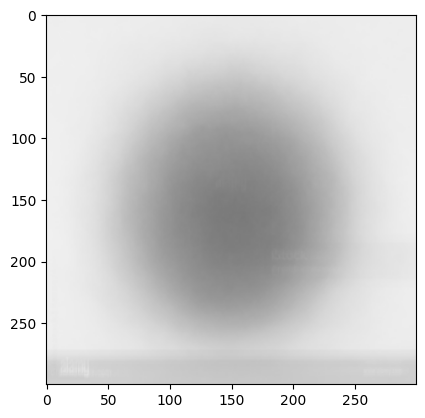

In [22]:
im =  Image.fromarray(average_fruit)
plt.gray()
plt.imshow(im)
plt.show()

In [23]:
#Demean the data matrix

fin = D - average_fruit_ini
a = np.mean(fin,axis=1)

(1071, 90000)


In [24]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(fin)

In [25]:
pca.explained_variance_ratio_[0]


0.2623722144705265

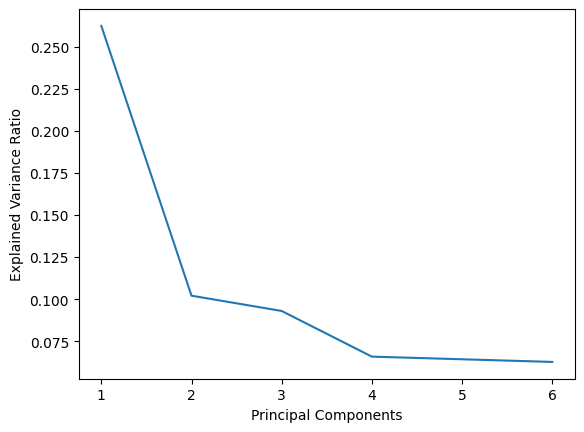

In [26]:
x = [1,2,3,4,6]
y = pca.explained_variance_ratio_[:5]
plt.plot(x,y)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [27]:
#take first 10 components
E= pca.components_[:5]
E.shape

(5, 90000)

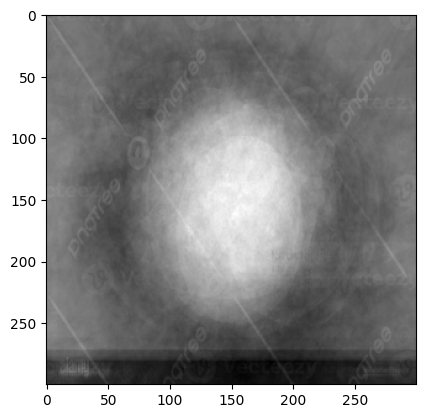

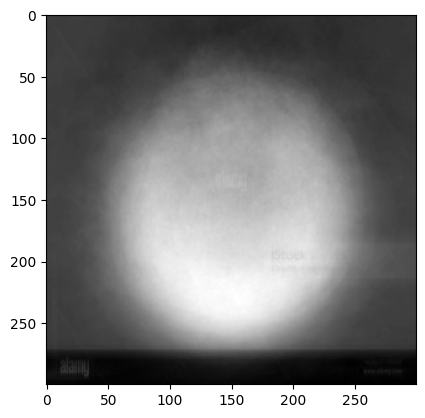

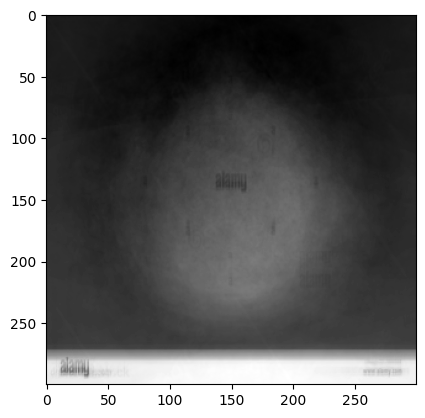

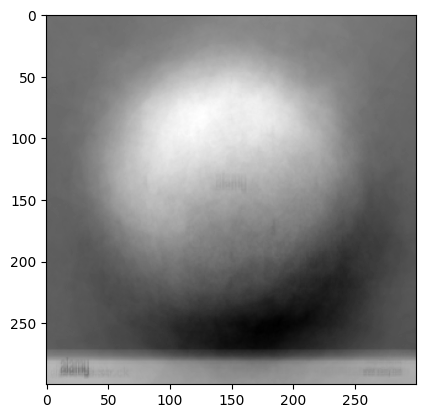

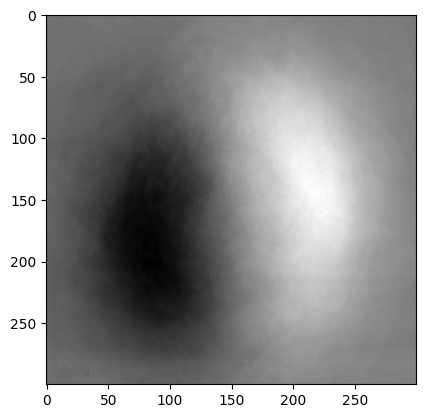

In [28]:
for i in range(len(E)):
    r = E[i].reshape(300,300)
    im =  Image.fromarray(r)
   
    plt.gray()
    plt.imshow(np.asarray(im))
    plt.show()

In [29]:
E = np.array(E)
D= np.array(D)
P = np.dot(D,E.T)
D = np.array(D)


In [30]:
from sklearn.model_selection import train_test_split
train_D, test_D, train_y, test_y = train_test_split(D, labels, test_size=0.2, random_state=0)
train_P,test_P,train_y_p,test_y_p = train_test_split(P,labels,test_size=0.2,random_state=0)
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_D, train_y)

In [31]:
pred_on_train = clf.predict(train_D)
from sklearn.metrics import accuracy_score

acc_rate = accuracy_score(pred_on_train,train_y)
print('Accuracy rate on train',acc_rate)

Accuracy rate on train 1.0


In [32]:
pred = clf.predict(test_D)
from sklearn.metrics import accuracy_score

acc_rate = accuracy_score(pred,test_y)
print('Accuracy rate',acc_rate)

Accuracy rate 0.3209302325581395


In [37]:
pred = clf.predict(test_D)
from sklearn.metrics import precision_score

per_rate = precision_score(pred,test_y, average="macro")
print('Percision Score',per_rate)

Percision Score 0.3083882222881611


In [38]:
import time

start_time = time.time()

pred = clf.predict(test_D)

end_time = time.time()

speed = (end_time - start_time) 
print("Speed: " + str(speed) + " to predict")


Speed: 0.0325167179107666 to predict


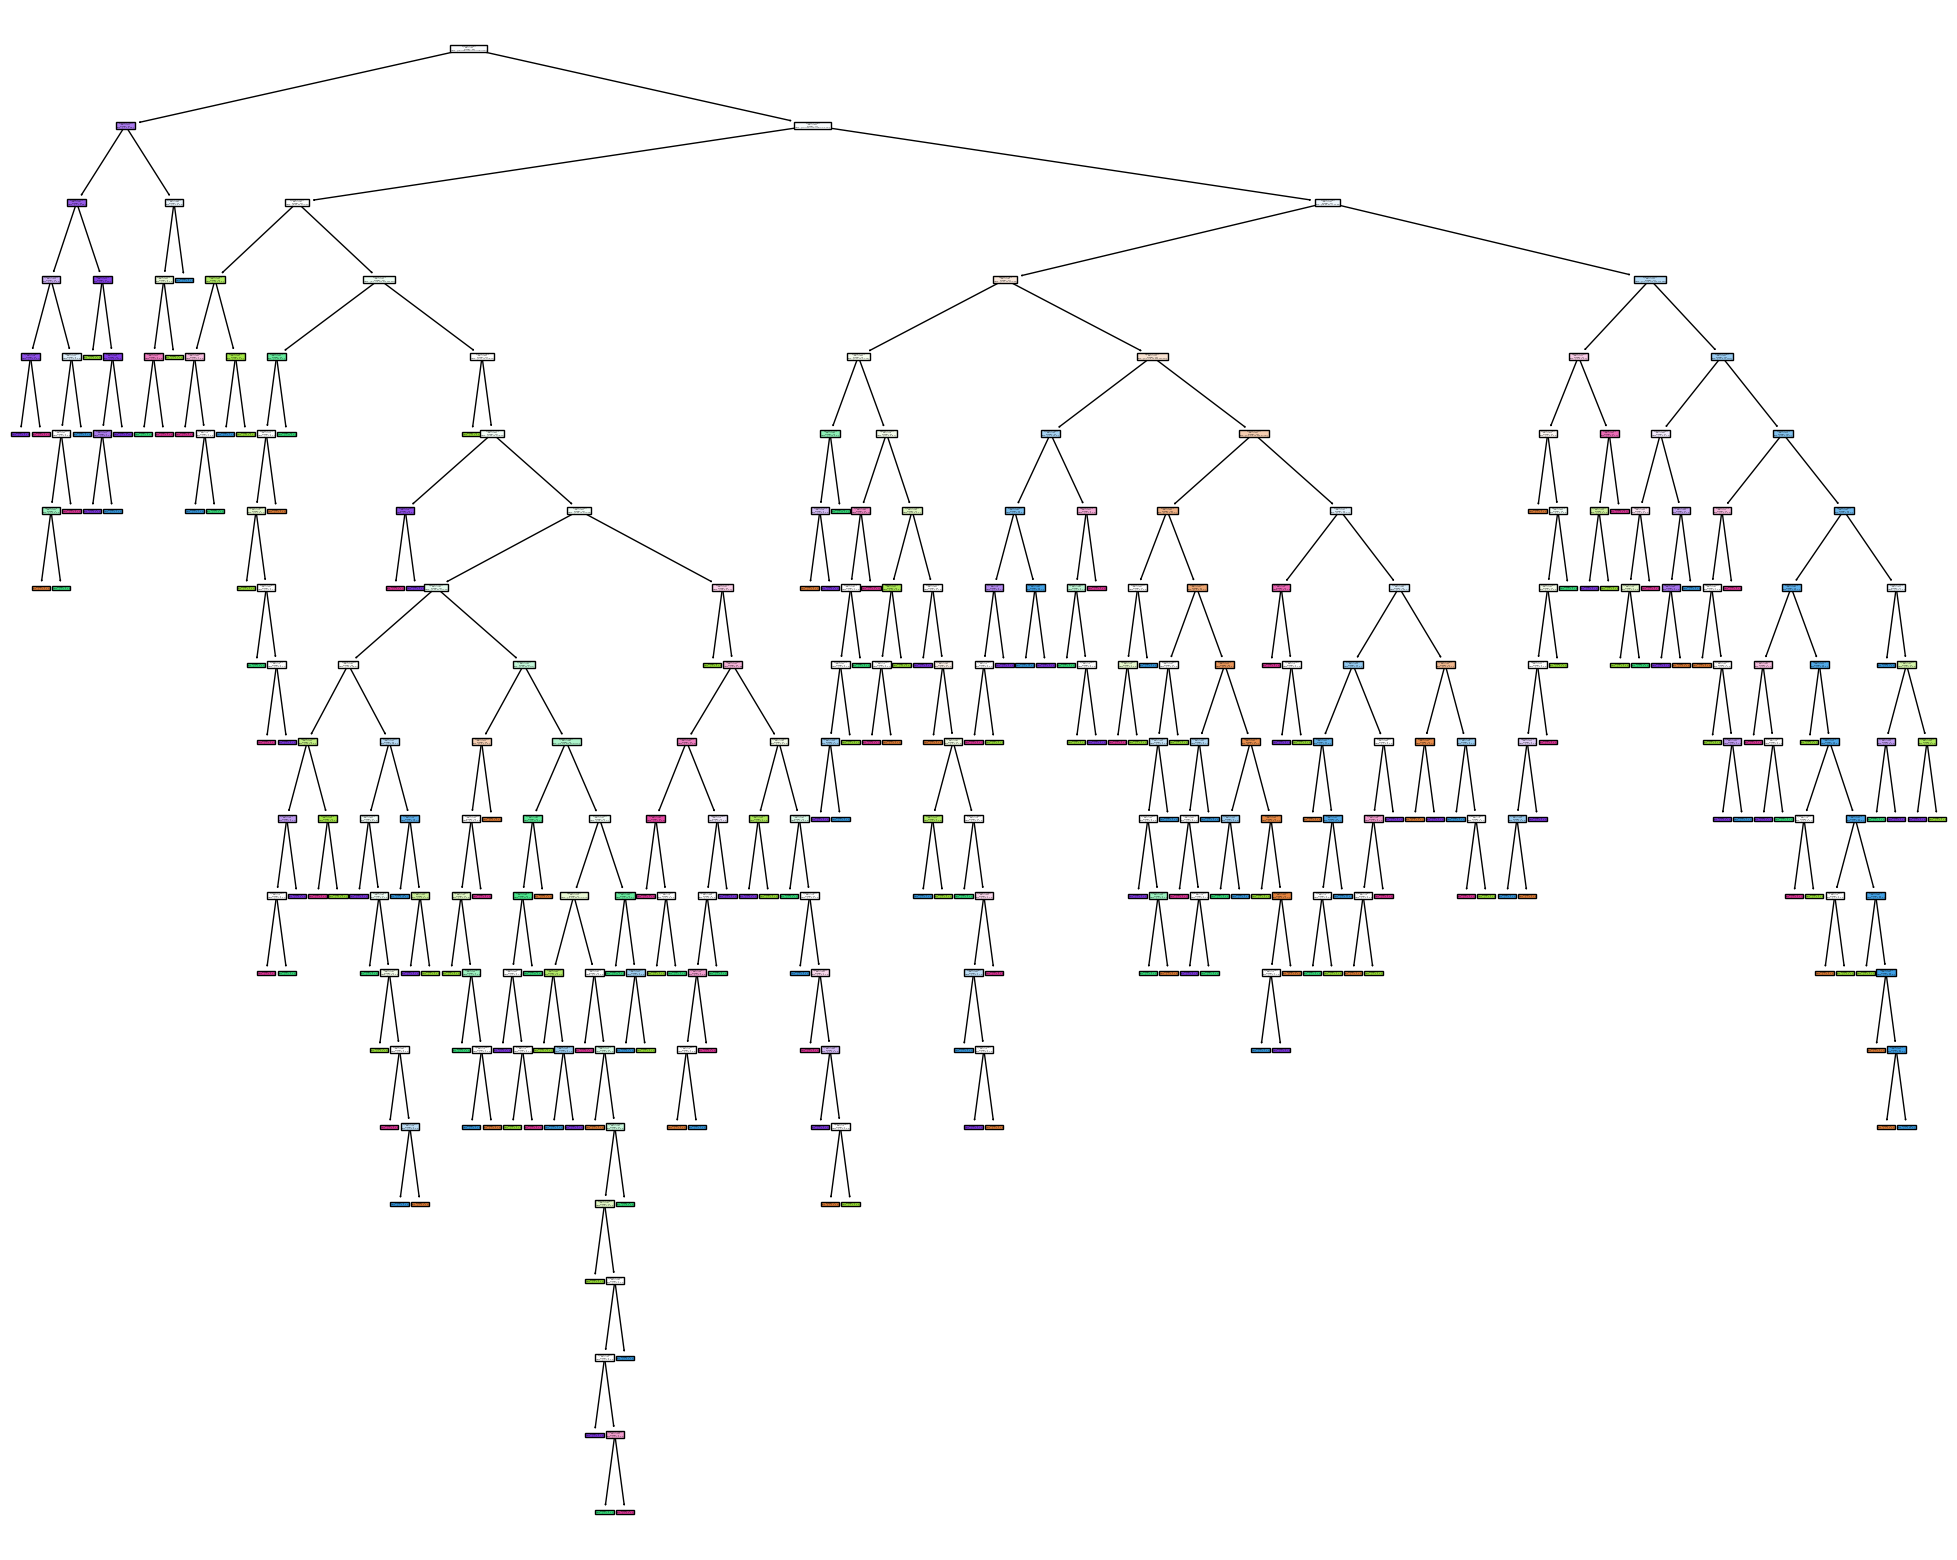

In [33]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   filled=True)